In [2]:
%matplotlib inline
from imports import *
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
order = ['node','Python','Ruby']
d = {'python':'Python','ruby':'Ruby'}
import effect_size
from tqdm.notebook import tqdm

## Analysis at the current date 

In [3]:
lag_release = pd.read_csv('../data/lag_today.csv')
lag_release.package.fillna('nan', inplace=True)
lag_release['last_updated'] = pd.to_datetime(lag_release['last_updated'])

# Filter on 3000 images
candidates_3000 = pd.read_csv('../data/considered_3000_images.csv')
mask = lag_release.image.isin(candidates_3000.image)
lag_release = lag_release[mask]
lag_release['base'] = lag_release['base'].replace(d)
lag_release.rename(columns = {'operating':'os'}, inplace=True)

# node images might have transitive dependencies, or the same version can be python2 or python3
lag_release.drop_duplicates(inplace=True)

len(lag_release)

472522

## Technical lag at the analysis date

In [4]:
lag_release['last_updated'] = pd.to_datetime(lag_release['last_updated'])
for x in ['major','minor','patch']:
    lag_release[x] = lag_release[x].apply(float)

In [5]:
lag_release['lag'] = lag_release.apply(lambda d : 'major' if d['major'] >0
                                      else 'minor' if d['minor'] >0
                                      else 'patch' if d['patch'] >0
                                      else "up-to-date", axis=1)

In [6]:
# Not core packages
added_package = lag_release.query('core == False')

# ALL PACKAGES

In [ ]:
### ALL PACKAGES
df_tmp = lag_release[['image','base','last_updated','package','lag']]
#df_tmp = df_tmp.query('base!="Python"')
df_tmp['update'] = df_tmp['lag'].apply(lambda x: 'out-of-date' if x!='up-to-date'
                                      else x)
df_tmp = (df_tmp
          .groupby(['image','base','last_updated','update'])
          .count()[['package']]
          .reset_index()
          .merge(df_tmp
                 .groupby(['image','base','last_updated'])
                 .count()[['package']]
                 .reset_index()
                 .rename(columns ={'package':'all'}),
                 on = ['image','base','last_updated'],
                 how = 'left'
                )
         )
df_tmp['package'] = df_tmp.apply(lambda d: d['package']*1.0/d['all'], axis=1)

# The ones with 0 will not be shown
df_tmp = (pd.concat([df_tmp[['image','base','last_updated']].drop_duplicates().assign(update = ver) for ver in df_tmp['update'].unique().tolist()])
      .merge(df_tmp,
             on = ['image','base','last_updated','update'],
             how = 'left'
            )
     )
df_tmp.fillna(0, inplace=True)

df_tmp['year'] = df_tmp['last_updated'].apply(lambda x: x.year)
#df_tmp['core'] = df_tmp['core'].replace({True:'Core packages', False:'Added packages'})

In [8]:
df_tmp.query('image =="178256/pilgrim_api"')

,image,base,last_updated,update,package,all,year
1,178256/pilgrim_api,node,2019-01-25,out-of-date,0.631579,380.0,2019
3001,178256/pilgrim_api,node,2019-01-25,up-to-date,0.368421,380.0,2019


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead


([<matplotlib.axis.YTick at 0x7f48b8c04128>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

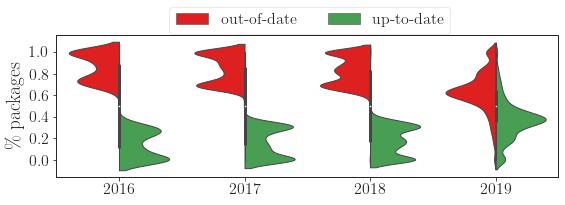

In [9]:
ax = sns.violinplot(x="year", 
                 y="package",
                   hue='update',
                 data=df_tmp,#.query('base =="{}"'.format(base)),
                   palette = [colors['major'],colors['up-to-date']],
                 linewidth=1,
                    split=True
                  )
ax.set(
    xlabel='',
    ylabel='\% packages',
)
ax.legend(ncol=4, prop={'size': 16, 'weight':'bold'}, bbox_to_anchor= (0.8, 1.26))
ax.figure.set_size_inches(9,2.6)
plt.yticks(pd.np.arange(0, 1.01, 0.2))  

In [18]:
df_tmp.groupby(['core','update'])['package'].describe()

count      mean      std       min       25%  \
core           update                                                       
Added packages out-of-date  2929.0  0.748413  0.20981  0.000000  0.620000   
               up-to-date   2929.0  0.251587  0.20981  0.000000  0.083333   
Core packages  out-of-date  2000.0  0.775616  0.16642  0.493042  0.637097   
               up-to-date   2000.0  0.224384  0.16642  0.000000  0.000000   

                                 50%       75%       max  
core           update                                     
Added packages out-of-date  0.772277  0.916667  1.000000  
               up-to-date   0.227723  0.380000  1.000000  
Core packages  out-of-date  0.690310  1.000000  1.000000  
               up-to-date   0.309690  0.362903  0.506958

## Let's compute by base

In [10]:
### ALL PACKAGES
df_tmp = lag_release[['image','base','last_updated','package','lag']]
df_tmp = (df_tmp
          .groupby(['image','base','last_updated','lag'])
          .count()[['package']]
          .reset_index()
          .merge(df_tmp
                 .groupby(['image','base','last_updated'])
                 .count()[['package']]
                 .reset_index()
                 .rename(columns ={'package':'all'}),
                 on = ['image','base','last_updated'],
                 how = 'left'
                )
         )
df_tmp['package'] = df_tmp.apply(lambda d: d['package']*1.0/d['all'], axis=1)

# The ones with 0 will not be shown
df_tmp = (pd.concat([df_tmp[['image','base','last_updated']].drop_duplicates().assign(lag = ver) for ver in df_tmp['lag'].unique().tolist()])
      .merge(df_tmp,
             on = ['image','base','last_updated','lag'],
             how = 'left'
            )
     )
df_tmp.fillna(0, inplace=True)

df_tmp['year'] = df_tmp['last_updated'].apply(lambda x: x.year)

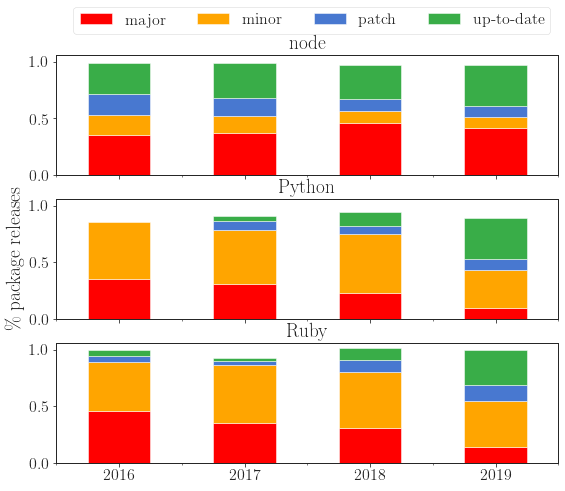

In [12]:
import matplotlib.pylab as pylab
params = {'axes.titlesize':'large',
         'axes.titleweight':'bold'}
plt.rcParams.update(params)
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
fig.set_size_inches(9,7.5)
for i, base in enumerate(order):
    df_ = (df_tmp.query('base == "'+base+'"')
     .groupby(['year','lag'])['package']
     .describe()[['50%']] # MEDIAN
     .rename(columns={'50%':'median'})
     .reset_index()
     .pivot_table(index=['year'], columns='lag', values='median')
     .reset_index()
     .set_index('year')
    )
    ax = df_.plot.bar(stacked=True, color = [colors[r] for r in ['major','minor','patch','up-to-date']], ax=axes[i])
    ax.set(
        xlabel='',
        ylabel='',
        title=base,
    )
    if base == "Python":
        ax.set_ylabel('\% package releases')
        
    ax.legend().remove()
ax.legend(ncol=4, prop={'size': 16, 'weight':'bold'}, bbox_to_anchor= (1, 3.87))
plt.xticks(rotation=0)

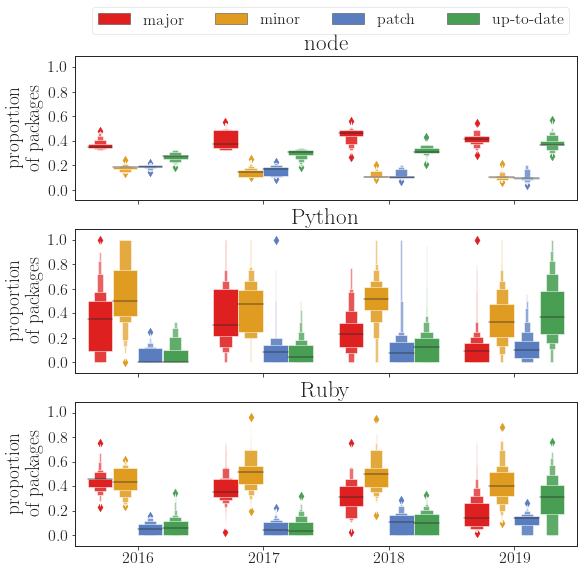

In [67]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
fig.set_size_inches(9,9)
for i, base in enumerate(order):
    ax = sns.boxenplot(x="year", 
                     y="package",
                       hue='lag',
                     hue_order = ['major','minor','patch','up-to-date'],
                     data=df_tmp.query('base =="{}"'.format(base)),
                     palette=[colors[r] for r in ['major','minor','patch','up-to-date']] , 
                     linewidth=1,
                     #showfliers= False,
                     ax=axes[i]
                      )
    ax.set(
        xlabel='',
        ylabel='proportion \nof packages',
        title=base,
    )

    plt.yticks(pd.np.arange(0, 1.01, 0.2)) 
    ax.legend().remove()
ax.legend(ncol=4, prop={'size': 16, 'weight':'bold'}, bbox_to_anchor= (1, 3.8))

In [89]:
df_tmp.groupby(['base','lag'])['package'].describe()

count      mean       std       min       25%       50%  \
base   lag                                                                    
Python major       1000.0  0.190020  0.183335  0.000000  0.066667  0.146341   
       minor       1000.0  0.419502  0.212951  0.000000  0.266176  0.428571   
       patch       1000.0  0.114557  0.137489  0.000000  0.000000  0.090909   
       up-to-date  1000.0  0.275921  0.246873  0.000000  0.090909  0.209914   
Ruby   major       1000.0  0.268867  0.149500  0.020747  0.137931  0.285714   
       minor       1000.0  0.457465  0.144472  0.101045  0.360656  0.428571   
       patch       1000.0  0.095075  0.072953  0.000000  0.000000  0.114190   
       up-to-date  1000.0  0.178594  0.173443  0.000000  0.000000  0.154084   
node   major       1000.0  0.421362  0.055516  0.265700  0.382500  0.437666   
       minor       1000.0  0.118267  0.030309  0.058743  0.100796  0.106557   
       patch       1000.0  0.118912  0.040923  0.035491  0.094737  0.100279   
       up-to-date  1000.0  0.341459  0.058034  0.182042  0.300546  0.336364   

                        75%       max  
base   lag                             
Python major       0.250000  1.000000  
       minor       0.562500  1.000000  
       patch       0.166667  1.000000  
       up-to-date  0.428571  1.000000  
Ruby   major       0.368225  0.750000  
       minor       0.545455  0.959732  
       patch       0.147541  0.282051  
       up-to-date  0.291481  0.761194  
node   major       0.477534  0.557659  
       minor       0.146341  0.250923  
       patch       0.145683  0.224215  
       up-to-date  0.363395  0.569937

## NOT CORE PACKAGES

In [25]:
### ONLY NOT CORE PACKAGES
df_tmp = (added_package
          .groupby(['image','base','os','last_updated','lag'])
          .count()[['package']]
          .reset_index()
          .merge(added_package
                 .groupby(['image','base','os','last_updated'])
                 .count()[['package']]
                 .reset_index()
                 .rename(columns ={'package':'all'}),
                 on = ['image','base','os','last_updated'],
                 how = 'left'
                )
         )
df_tmp['package'] = df_tmp.apply(lambda d: d['package']*1.0/d['all'], axis=1)

df_tmp = (pd.concat([df_tmp[['image','base','os','last_updated']].drop_duplicates().assign(lag = ver) for ver in df_tmp.lag.unique().tolist()])
      .merge(df_tmp,
             on = ['image','base','os','last_updated','lag'],
             how = 'left'
            )
     )
df_tmp.fillna(0, inplace=True)


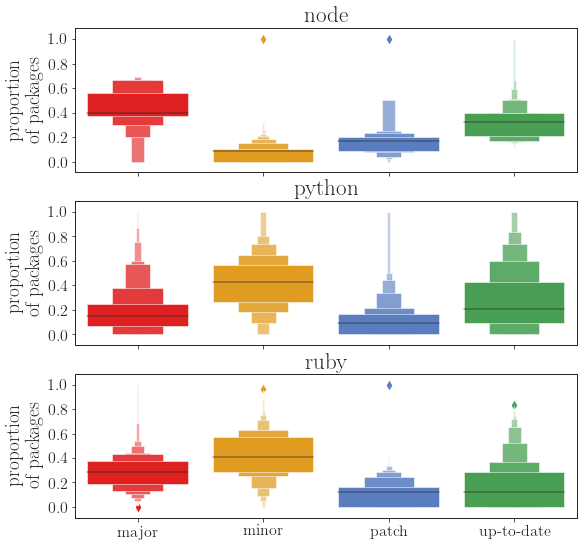

In [26]:
df_tmp['year'] = df_tmp['last_updated'].apply(lambda x: x.year)
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
fig.set_size_inches(9,9)
for i, base in enumerate(order):
    ax = sns.boxenplot(x="lag", 
                     y="package",
                     order = ['major','minor','patch','up-to-date'],
                     data=df_tmp.query('base =="{}"'.format(base)),
                     palette=[colors[r] for r in ['major','minor','patch','up-to-date']] , 
                     linewidth=1,
                     #showfliers= False,
                     ax=axes[i]
                      )
    ax.set(
        xlabel='',
        ylabel='proportion \nof packages',
        title=base,
    )

    plt.yticks(pd.np.arange(0, 1.01, 0.2))  


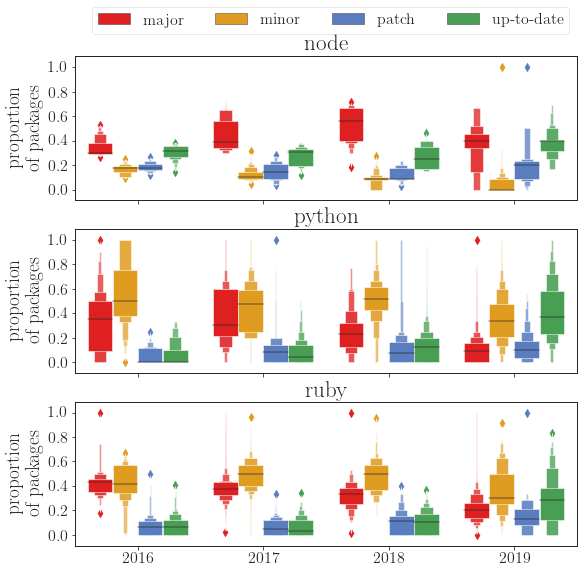

In [27]:
df_tmp['year'] = df_tmp['last_updated'].apply(lambda x: x.year)
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
fig.set_size_inches(9,9)
for i, base in enumerate(order):
    ax = sns.boxenplot(x="year", 
                     y="package",
                       hue='lag',
                     hue_order = ['major','minor','patch','up-to-date'],
                     data=df_tmp.query('base =="{}"'.format(base)),
                     palette=[colors[r] for r in ['major','minor','patch','up-to-date']] , 
                     linewidth=1,
                     ax=axes[i]
                      )
    ax.set(
        xlabel='',
        ylabel='proportion \nof packages',
        title=base,
    )
    ax.legend().remove()
    plt.yticks(pd.np.arange(0, 1.01, 0.2)) 
ax.legend(ncol=4, prop={'size': 16, 'weight':'bold'}, bbox_to_anchor= (1, 3.8))

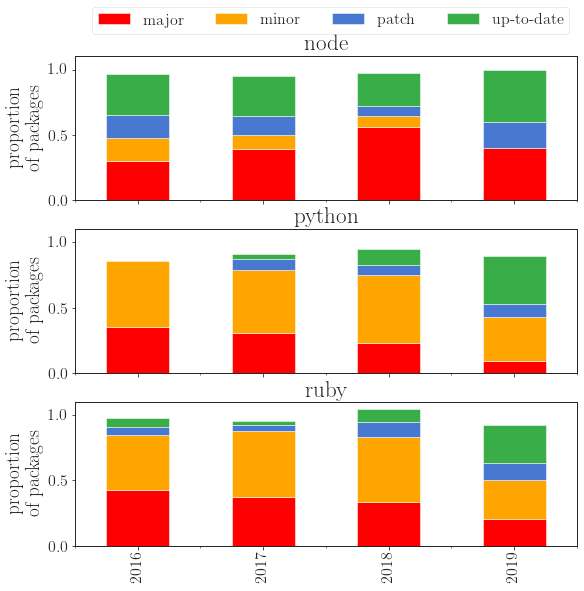

In [28]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True)
fig.set_size_inches(9,9)
for i, base in enumerate(order):
    df_ = (df_tmp.query('base == "'+base+'"')
     .groupby(['year','lag'])['package']
     .describe()[['50%']] # MEDIAN
     .rename(columns={'50%':'median'})
     .reset_index()
     .pivot_table(index=['year'], columns='lag', values='median')
     .reset_index()
     .set_index('year')
    )
    ax = df_.plot.bar(stacked=True, color = [colors[r] for r in ['major','minor','patch','up-to-date']], ax=axes[i])
    ax.set(
        xlabel='',
        ylabel='proportion \nof packages',
        title=base,
    )
        
    ax.legend().remove()
ax.legend(ncol=4, prop={'size': 16, 'weight':'bold'}, bbox_to_anchor= (1, 3.8))

## Available packages

In [16]:

RE_SEMVER = r'^(?:v|V)?(?P<Major>\d+)\.(?P<Minor>\d+)\.(?P<Patch>\d+)(?P<v_misc>.*)$'

def release_type(package, major, minor, package_previous, major_previous,minor_previous):
    if package != package_previous:
        return 'initial'
    if major != major_previous:
        return 'major'
    if minor != minor_previous:
        return 'minor'
    return 'patch'


available = pd.concat([
    pd.read_csv('../data/'+x, dtype=str) 
    for x in ['npm_versions.csv','pypi_versions.csv','ruby_versions.csv']])
available.package.fillna('nan', inplace=True)
available['version'] = available['version'].apply(lambda x: x+'.0' if x.count('.')==1
                                                 else x)
available = pd.concat([available,available.version.str.extract(RE_SEMVER, expand=True)],axis=1)
available.fillna('undefined', inplace=True)
    
# Filter versions that we cannot use MAJOR.MINOR.PATCH with them

p = available.query('Major == "undefined"').package
available = available[~available.package.isin(p)]

for col in ['Major','Minor','Patch']:
    available[col] = available[col].apply(int)
    
available.sort_values(['base','package','Major','Minor','Patch'], inplace=True)
available['Major_previous'] = available['Major'].shift(1)
available['Minor_previous'] = available['Minor'].shift(1)
available['package_previous'] = available['package'].shift(1)

available ['release-type'] = available.apply(lambda d: 
                                                  release_type(d['package'],
                                                               d['Major'],
                                                               d['Minor'],
                                                               d['package_previous'],
                                                               d['Major_previous'],
                                                               d['Minor_previous']
                                                              ), axis=1)
available['zero'] = available['Major'].apply(lambda x: x==0)
available.rename(columns = {'version':'version_compare'}, inplace=True)

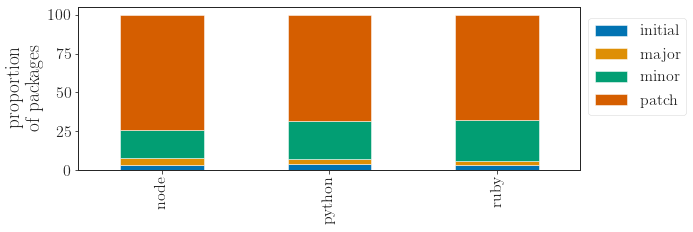

In [20]:
tmp = (available.groupby(['base','release-type']).count()[['package']]*100/available.groupby(['base']).count()[['package']])
tmp = (tmp
       .reset_index()
 .pivot_table(index=['base'], columns='release-type', values='package')
 .reset_index()
 .set_index('base')
)

ax = tmp.plot.bar(stacked=True)
ax.set(
    xlabel='',
    ylabel='proportion \nof packages'    #ylim=(0,200),
)
ax.legend(ncol=1, prop={'size': 16, 'weight':'bold'},  bbox_to_anchor= (1,0.98))
ax.figure.set_size_inches(9,3)

In [21]:
tmp

release-type,initial,major,minor,patch
base,,,,
node,3.165544,4.847818,17.960594,74.026044
python,3.958515,2.917335,24.501757,68.622392
ruby,3.134774,2.859873,26.533813,67.471541


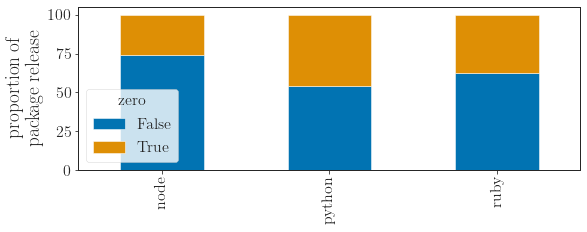

In [18]:
tmp = available.groupby(['base','zero']).count()[['package']]*100/available.groupby(['base']).count()[['package']]

tmp = (tmp
       .reset_index()
 .pivot_table(index=['base'], columns='zero', values='package')
 .reset_index()
 .set_index('base')
)

ax = tmp.plot.bar(stacked=True)
ax.set(
    xlabel='',
    ylabel='proportion of \npackage release'    #ylim=(0,200),
)
ax.figure.set_size_inches(9,3)


In [19]:
tmp

zero,False,True
base,,
node,74.408515,25.591485
python,54.224651,45.775349
ruby,62.410657,37.589343


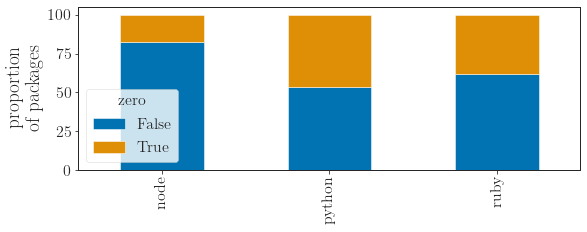

In [33]:
#how many package are still in ZERO
tmp = (available
 .sort_values(['Major','Minor','Patch','date'])
 .groupby(['base','package'])
 .last()
 .reset_index()
)
tmp = tmp[['base','package','zero']].drop_duplicates().groupby(['base','zero']).count()[['package']]*100/tmp[['base','package','zero']].drop_duplicates().groupby(['base']).count()[['package']]
tmp = (tmp
       .reset_index()
 .pivot_table(index=['base'], columns='zero', values='package')
 .reset_index()
 .set_index('base')
)

ax = tmp.plot.bar(stacked=True)
ax.set(
    xlabel='',
    ylabel='proportion \nof packages'    #ylim=(0,200),
)
ax.figure.set_size_inches(9,3)
